In [5]:
%pip install lenskit
%pip install pyarrow

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [40]:
from lenskit import batch, topn, util
from lenskit import crossfold as xf
from lenskit.algorithms import Recommender, als, item_knn as knn
from lenskit import topn
import time

In [41]:
import pandas as pd

In [42]:
# ratings = pd.read_csv('/scratch/work/courses/DSGA1004-2021/movielens/ml-latest-small/ratings.csv')
ratings_train = pd.read_parquet('train_combined_large_set.parquet')
ratings_val = pd.read_parquet('val_large_set.parquet')

In [43]:
ratings_train

,userId,movieId,rating,timestamp
0,148,1,4.0,858751867
1,148,3,3.0,858751912
2,148,5,2.0,858751912
3,148,7,3.0,858751912
4,148,17,4.0,858751867
...,...,...,...,...
18460066,282369,148626,3.0,1480705064
18460067,282369,7153,1.0,1480705071
18460068,282369,6377,2.0,1480705088
18460069,282369,7361,5.0,1480705095


In [44]:
ratings_train.columns = ratings_train.columns.str.replace('userId', 'user')
ratings_train.rename(columns = {'userId':'user', 'movieId':'item'}, inplace = True)
ratings_val.columns = ratings_val.columns.str.replace('userId', 'user')
ratings_val.rename(columns = {'userId':'user', 'movieId':'item'}, inplace = True)

In [45]:
ratings_val

,user,timestamp,item,rating
0,463,841895884,16,3.0
1,463,841895884,213,3.0
2,463,841895951,308,4.0
3,463,841895981,105,2.0
4,463,841896053,246,3.0
...,...,...,...,...
4689038,282930,849119359,589,4.0
4689039,282930,849119360,377,3.0
4689040,282930,849119360,454,4.0
4689041,282930,849123746,47,4.0


In [46]:
algo_ii = knn.ItemItem(20)
algo_als = als.BiasedMF(50,iterations=15)

In [47]:
def eval(aname, algo, train, test):
    fittable = util.clone(algo)
    fittable = Recommender.adapt(fittable)
    fittable.fit(train)
    users = test.user.unique()
    # now we run the recommender
    recs = batch.recommend(fittable, users, 100)
    # add the algorithm name for analyzability
    recs['Algorithm'] = aname
    return recs

In [48]:

start_time = time.time()

# rec_item = eval('ItemItem',algo_ii, ratings_train, ratings_val)
rec_ALS = eval('ALS', algo_als, ratings_train, ratings_val)
    
    
finish_time = time.time()
print("----- %s seconds -----", finish_time - start_time)

----- %s seconds ----- 590.5163872241974


In [49]:
rla = topn.RecListAnalysis()
rla.add_metric(topn.ndcg)
results_ALS = rla.compute(rec_ALS, ratings_val)
results_ALS.head()

nrecs      ndcg
Algorithm user                 
ALS       463     100  0.003703
          833     100  0.000000
          1591    100  0.000000
          2866    100  0.000000
          3175    100  0.000000

In [50]:
results_ALS.groupby('Algorithm').ndcg.mean()

Algorithm
ALS    0.034445
Name: ndcg, dtype: float64

<AxesSubplot:xlabel='Algorithm'>

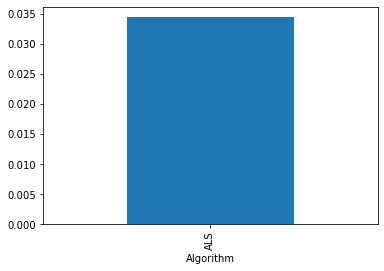

In [51]:
results_ALS.groupby('Algorithm').ndcg.mean().plot.bar()